In [1]:
#import the most used things
print("importing...")

from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stderr():
    with open(os.devnull, "w") as devnull:
        old_stderr = sys.stderr
        sys.stderr = devnull
        try:  
            yield
        finally:
            sys.stderr = old_stderr

with suppress_stderr():
    import deepchem as dc
    import pandas as pd
    import numpy as np

importing...
Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [3]:
print("colecting data...")
tasks, data, transformers = dc.molnet.load_hopv(featurizer=dc.feat.MACCSKeysFingerprint(), splitter = None)

colecting data...


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\wanne\\AppData\\Local\\Temp\\hopv-featurized\\MACCSKeysFingerprint\\None\\NormalizationTransformer_transform_y_True\\transformers.pkl'

In [52]:
#convert the dataset so that no more nan is present and selct the y-values of the homo gap toghether with the according wheigths
dataset = data[0]
#converting the train set
X = np.nan_to_num(dataset.X, copy=True, nan=0.0)
Y = dataset.y[:,[0]]
w = dataset.w[:,[0]]
ids = dataset.ids
Task = dataset.tasks[0]


#find al the positive values and delete them
to_del = []
for idx, value in enumerate(Y):
    
    if value[0] > 0:
        to_del.append(idx)


X = np.delete(X,to_del,0)
Y = np.delete(Y,to_del).reshape(-1, 1)
w = np.delete(w,to_del).reshape(-1, 1)
ids = np.delete(ids,to_del)
#add the cenverted data to new dataframe
new_data= dc.data.DiskDataset.from_numpy(X=X, y=Y, w=w, ids=data[0].ids, tasks = [Task])
print(new_data.tasks)

['HOMO']


In [53]:
#split the data in train and test samples
splitter = dc.splits.SingletaskStratifiedSplitter()
train_dataset, test_dataset = splitter.train_test_split(new_data, frac_train=0.8)

In [64]:
# create the GPR model & fit the model
from sklearn.ensemble import ExtraTreesRegressor


model = dc.models.SklearnModel(ExtraTreesRegressor(n_estimators=200, random_state=0))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted!")

#predict the test set
predicted = model.predict(test_dataset)

fitting model...
model is fitted!


In [65]:
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set score:',test_score )

Training set score: {'pearson_r2_score': 0.8294779410959476}
Test set score: {'pearson_r2_score': 0.3081390940638226}


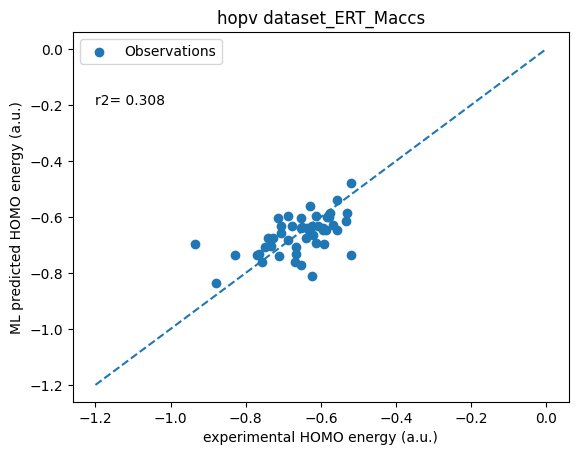

In [66]:
#convert tekst to string, so it can be depicted in matplotlib
number=list(test_score.values())[0]
text = "r2= "+ str(round(number,3))


#plot the data
import matplotlib.pyplot as plt

x=[-1.2,0]
y=[-1.2,0]
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label="Observations")
plt.legend()
plt.xlabel("experimental HOMO energy (a.u.)")
plt.ylabel("ML predicted HOMO energy (a.u.)")
plt.title("hopv dataset_ERT_Maccs")
plt.text(-1.2,-0.2,text)
plt.show()